## 4-5、AutoGraph和tf.Module
有三种计算图的构建方式：静态计算图，动态计算图，以及Autograph。

TensorFlow 2.0主要使用的是动态计算图和Autograph。

动态计算图易于调试，编码效率较高，但执行效率偏低。

静态计算图执行效率很高，但较难调试。

而Autograph机制可以将动态图转换成静态计算图，兼收执行效率和编码效率之利。

当然Autograph机制能够转换的代码并不是没有任何约束的，有一些编码规范需要遵循，否则可能会转换失败或者不符合预期。

前面我们介绍了Autograph的编码规范和Autograph转换成静态图的原理。

本篇我们介绍使用tf.Module来更好地构建Autograph。

### 一，Autograph和tf.Module概述
前面在介绍Autograph的编码规范时提到构建Autograph时应该避免在@tf.function修饰的函数内部定义tf.Variable.

但是如果在函数外部定义tf.Variable的话，又会显得这个函数有外部变量依赖，封装不够完美。

一种简单的思路是定义一个类，并将相关的tf.Variable创建放在类的初始化方法中。而将函数的逻辑放在其他方法中。

这样一顿猛如虎的操作之后，我们会觉得一切都如同人法地地法天天法道道法自然般的自然。

惊喜的是，TensorFlow提供了一个基类tf.Module，通过继承它构建子类，我们不仅可以获得以上的自然而然，而且可以非常方便地管理变量，还可以非常方便地管理它引用的其它Module，最重要的是，我们能够利用tf.saved_model保存模型并实现跨平台部署使用。

实际上，tf.keras.models.Model,tf.keras.layers.Layer 都是继承自tf.Module的，提供了方便的变量管理和所引用的子模块管理的功能。

因此，利用tf.Module提供的封装，再结合TensoFlow丰富的低阶API，实际上我们能够基于TensorFlow开发任意机器学习模型(而非仅仅是神经网络模型)，并实现跨平台部署使用。

### 二，应用tf.Module封装Autograph
定义一个简单的function。

In [1]:
import tensorflow as tf 
import numpy as np 

In [3]:
x = tf.Variable(1.0, dtype=tf.float32)

# 在tf.function中用input_signature限定输入张量的签名类型：shape和dtype
@tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.float32)])
def add_print(a):
    x.assign_add(a)
    tf.print(x)
    return x

add_print(tf.constant(3.0, dtype=tf.float32))

4


<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [10]:
add_print(tf.constant(3)) # 输入不符合张量签名的参数将报错

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(3, shape=(), dtype=int32))
  input_signature: (
    TensorSpec(shape=(), dtype=tf.float32, name=None))

下面利用tf.Module的子类化将其封装一下。

In [25]:
class DemoModule(tf.Module):
    def __init__(self,init_value = tf.constant(0.0),name=None):
        super(DemoModule, self).__init__(name=name)
        with self.name_scope:  #相当于with tf.name_scope("demo_module")
            self.x = tf.Variable(init_value,dtype = tf.float32,trainable=True)


    @tf.function(input_signature=[tf.TensorSpec(shape = [], dtype = tf.float32)])  
    def addprint(self,a):
        with self.name_scope:
            self.x.assign_add(a)
            tf.print(self.x)
            return(self.x)

In [26]:
demo = DemoModule(init_value=tf.constant(1.0))
result = demo.addprint(tf.constant(5.0))

6


In [27]:
# 查看模块中的全部变量和全部可训练变量
print(demo.variables)
print(demo.trainable_variables)

(<tf.Variable 'demo_module/Variable:0' shape=() dtype=float32, numpy=6.0>,)
(<tf.Variable 'demo_module/Variable:0' shape=() dtype=float32, numpy=6.0>,)


In [28]:
# 查看模块中的全部子模块
demo.submodules

()

In [29]:
# 使用tf.saved_model 保存模型，并指定需要跨平台部署的方法
tf.saved_model.save(demo,"../data/demo/1",signatures = {"serving_default":demo.addprint})

W0415 10:36:11.404803 4506095040 deprecation.py:506] From /Users/ting/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [30]:
# 加载模型
demo2 = tf.saved_model.load("../data/demo/1") 
demo2.addprint(tf.constant(5.0))

11


<tf.Tensor: shape=(), dtype=float32, numpy=11.0>

In [31]:
# 查看模型文件相关信息，红框标出来的输出信息在模型部署和跨平台使用时有可能会用到
!saved_model_cli show --dir ../data/demo/1 --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['a'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: serving_default_a:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_0'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0415 10:37:33.002349 4577926592 deprecation.py:506] From /Users/ting/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/resource_variable_op

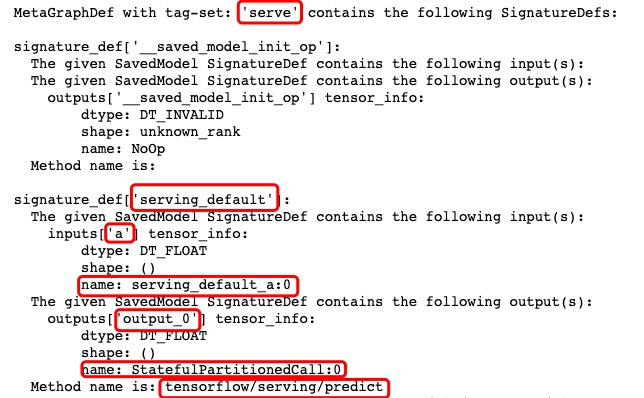

在tensorboard中查看计算图，模块会被添加模块名demo_module,方便层次化呈现计算图结构。

In [32]:
import datetime

# 创建日志
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = '../data/demomodule/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

#开启autograph跟踪
tf.summary.trace_on(graph=True, profiler=True) 

#执行autograph
demo = DemoModule(init_value = tf.constant(0.0))
result = demo.addprint(tf.constant(5.0))

#将计算图信息写入日志
with writer.as_default():
    tf.summary.trace_export(
        name="demomodule",
        step=0,
        profiler_outdir=logdir)

5


In [33]:
#启动 tensorboard在jupyter中的魔法命令
%reload_ext tensorboard

In [34]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [35]:
notebook.start("--logdir ../data/demomodule/")

除了利用tf.Module的子类化实现封装，我们也可以通过给tf.Module添加属性的方法进行封装。

In [36]:
mymodule = tf.Module()
mymodule.x = tf.Variable(0.0) 

@tf.function(input_signature=[tf.TensorSpec(shape = [], dtype = tf.float32)])
def addprint(a):
    mymodule.x.assign_add(a)
    tf.print(mymodule.x)
    return mymodule.x

mymodule.addprint = addprint

In [37]:
mymodule.addprint(tf.constant(1.0))

1


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [38]:
print(mymodule.variables)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,)


In [39]:
print(mymodule.trainable_variables)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,)


In [41]:
# 使用tf.saved_model 保存模型
tf.saved_model.save(mymodule,"../data/mymodule", signatures={"serving_default": mymodule.addprint})

In [42]:
# 使用tf.save_model 加载模型
mymodule2 = tf.saved_model.load("../data/mymodule")
mymodule2.addprint(tf.constant(5.0))

6


<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

### 三，tf.Module和tf.keras.Model，tf.keras.layers.Layer
tf.keras中的模型和层都是继承tf.Module实现的，也具有变量管理和子模块管理功能。

In [43]:
from tensorflow.keras import models, layers, losses, metrics

In [44]:
print(issubclass(tf.keras.Model,tf.Module))
print(issubclass(tf.keras.layers.Layer,tf.Module))
print(issubclass(tf.keras.Model,tf.keras.layers.Layer))

True
True
True


In [45]:
# 清除已有的session
tf.keras.backend.clear_session() 

model = models.Sequential()

model.add(layers.Dense(4, input_shape=(10, )))
model.add(layers.Dense(2))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 44        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(10, 4) dtype=float32, numpy=
 array([[ 0.53695405,  0.05620033,  0.09951526, -0.31512827],
        [-0.4807819 ,  0.4178928 ,  0.12274021, -0.05245531],
        [-0.5249939 , -0.08403838,  0.35111022,  0.3860606 ],
        [-0.6007145 , -0.2853632 , -0.09988207, -0.19501242],
        [ 0.15868473,  0.2192272 ,  0.56785417, -0.41411227],
        [ 0.65442204, -0.3901723 ,  0.64881027, -0.54039884],
        [-0.56155336,  0.6374084 ,  0.2193892 ,  0.4093889 ],
        [ 0.49068308, -0.08065361,  0.5391797 ,  0.06639636],
        [-0.40769044, -0.61990255,  0.24275744, -0.00351542],
        [-0.22739342,  0.10904592, -0.65306616,  0.20176655]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-0.60091686, -0.37986255],
        [-0.69266725, -0.9217701 ],
        [ 0.9125221 , -0.955179  ],
        [ 

In [48]:
model.layers[0].trainable = False
model.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-0.60091686, -0.37986255],
        [-0.69266725, -0.9217701 ],
        [ 0.9125221 , -0.955179  ],
        [ 0.38509536, -0.2956195 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.68557817],
        [ 1.0853525 ]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [50]:
model.submodules

(<tensorflow.python.keras.engine.input_layer.InputLayer at 0x13fb2d400>,
 <tensorflow.python.keras.layers.core.Dense at 0x13fb08978>)

In [51]:
model.layers

In [52]:
print(model.name)

sequential


In [53]:
print(model.name_scope)

<bound method Layer._name_scope of <tensorflow.python.keras.engine.sequential.Sequential object at 0x13fb614e0>>
